In [5]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pytensor
from scipy.optimize import least_squares
import math
from photonic_hamiltonian.inference import io_data
#load an example data file, data courtersy: Fan Du
real_data = io_data.load_data('photonic_hamiltonian\data\expdata4_GM0p065.nc')

In [6]:
# infer ex delta
from pytensor import tensor as pt
import numpy as np
import pymc as pm
import pytensor

def Hamiltonian_model(data,prior_bounds):
    """
    returns a pymc model to infer the parameters for a four-basis Hamiltonian.
    The piors on all parameters ~ Uniform(given lower, given upper)
    The likelihood ~ Gaussian(line, sigma_y)
    Line is the expectation value obtained by taking the sum of background and 4 Gaussian peaked
    at the eigenvalues of 4x4 Hamiltonian matrix
    
    Parameters:
        data: the data set of a single-momentum spectrum 
              (DataArray with 'x': frequency, 'y': intensity, and 'sigma_y': intensity uncertainty)
        prior_bounds: the bounds for uniform priors of all parameters we want to infer
              (dict mapping a string, name of the parameter, to a list of its bounds [lower, upper])
              
    Return:
        ham_model: the pymc model can be used to infer the parameters and their posterior
              (pymc Model object)
    
    """
    #extract data to numpy arrays
    freq = real_data['normf'].to_numpy()
    Nf = len(freq)
    namef = ['y1','y2','y3','y4']
    y = np.zeros((4,Nf))
    y[:] = [real_data[namef[i]].to_numpy() for i in range(4)]

    kx = 0.05
    ky = 0
    #define likelihood function
    def likelihood(theta, y, x):
        """
        returns the loglike likelihood of our model
        
        Parameters:
            theta: the parameters in Hamiltonian matrix (list)
            y, x, sigma_y: our data (numpy arrays)
        
        Return:
            the loglike likelihood (float)
        """
        #for our four-basis Hamiltonian, the parameters include
        #interaction-between-modes terms u11, u20;
        #background A0 and heights of 4 peaks A1, A2, A3, A4
        #peak width (assumed to be the same for all peaks) sigma_L
        u11, u20, e0, de, A0, A1, A2, A3, A4, W1, W2, W3, W4, sigma_y = theta
        ex = e0+de   # for k = (0, +-0.05) the energy of uncoupled slab mode 1 
        ey = e0-de   # for k = (+-0.05,0) the energy of uncoupled slab mode 2
        ham = pytensor.shared(np.zeros((4,4)))
        #Hamiltonian matrix
        ham_np = np.array([[ex,u11,u20,u11],
                           [u11,ey,u11,u20],
                           [u20,u11,ey,u11],
                           [u11,u20,u11,ex]])
        
        for row in range(4):
            for col in range(4):
               
                ham = pt.set_subtensor(ham[row, col], ham_np[row, col])
        
        #peak heights and peak positions
        An_np = np.array([A1,A2,A3,A4])
        An = pytensor.shared(np.zeros(4))
        Wn_np = np.array([W1, W2, W3, W4])
        Wn = pytensor.shared(np.zeros(4))
        for col in range(4):
            An = pt.set_subtensor(An[col], An_np[col])
            Wn = pt.set_subtensor(Wn[col], Wn_np[col])

        Cn = pt.nlinalg.eigh(ham)[0]
                   
        # make sure eigenvalues are sorted
        Cn = pt.sort(Cn)

        #expectation value as sum of 4 gaussian peaks and background
        line0 = An[0]*pt.sqr(Wn[0])/(pt.sqr(x-Cn[0])+pt.sqr(Wn[0])) + An[1]*pt.sqr(Wn[1])/(pt.sqr(x - Cn[1])+pt.sqr(Wn[1])) + An[2]*pt.sqr(Wn[2])/(pt.sqr(x - Cn[2])+pt.sqr(Wn[2]))+An[3]*pt.sqr(Wn[3])/(pt.sqr(x - Cn[3])+pt.sqr(Wn[3]))
        line = A0+line0
        
        return pt.sum(-(0.5 / pt.sqr(sigma_y)) * pt.sqr(y - line))
    
    #create the multi Gaussian peak model
    ham_model = pm.Model()
    with ham_model:
        # Priors for unknown model parameters
        theta_list = []
        for i in list(prior_bounds.keys()):
            #check if the lower bound is strictly smaller than the upper bound
            if prior_bounds[i][0] >= prior_bounds[i][1]:
                raise ValueError
            
            theta_list.append(pm.Uniform(i, lower=prior_bounds[i][0], upper=prior_bounds[i][1]))
    
        #input of our log-likelihood
        theta = pt.as_tensor_variable(theta_list)
    
        # Likelihood of observations
        pm.Potential("likelihood", likelihood(theta,y, freq))

    return ham_model

def fit_curve(freq, theta):
    """
    Calculate the multi Gaussian peak curve fit using a set of given fitting parameters

    Parameters
    ----------
    freq (NumPy array):
        The array of normalized frequency (x data)
    theta (list):
        The list of fitting parameters, in the order u11, u20, A0, A1, A2, A3, A4, sigma_L
        
    Return
    ---------
    line (NumPy array):
        The array of corresponding fitted intensity
    """

    u11, u20, e0,de, A0, A1, A2, A3, A4, W1, W2, W3, W4 = theta
    An = [A1, A2, A3, A4]
    Wn = [W1, W2, W3, W4]
    ex = e0+de   # for k = (0, +-0.05) the energy of uncoupled slab mode 1 
    ey = e0-de   # for k = (+-0.05,0) the energy of uncoupled slab mode 2

    #Hamiltonian matrix and its eigenvalues as line peaks
    H = [[ex,u11,u20,u11],
         [u11,ey,u11,u20],
         [u20,u11,ey,u11],
         [u11,u20,u11,ex]]
    Cn = np.real(np.linalg.eigvals(H))
    Cn = np.sort(Cn)
    
    #calculate normalized intensity
    line = [(Ai * Wi**2)/((freq- Ci)**2 + Wi**2) for Ai, Ci, Wi in zip(An, Cn, Wn)]
    
    #line_each = [Ai * np.exp(-(freq - Ci)**2 / (2 * sigma_L**2)) for Ai, Ci in zip(An, Cn)]
    line = np.sum(line, axis=0) + A0
    
    return line

Text(0.5, 1.0, 'Simulated data showing four energy bands of a single C4-symmetric photonic crystal')

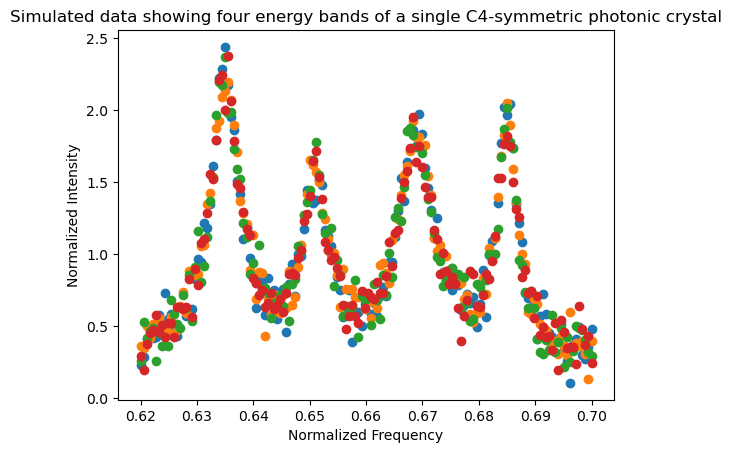

In [59]:
# Create simulated data
N = 150
simu_normf = np.linspace(0.62,0.70,N)    # create normalized frequency, "x" variable 

#set all hamiltonian parameters as some constants
u11 = 0.008
u20 = 5e-5
e0 = 0.66
de = 0.015
A0 = 0.3
[A1,A2,A3,A4] = [1.9,1.2,1.5,1.6]
[W1,W2,W3,W4] = [0.003,0.0026,0.0036,0.002]
theta = [u11, u20, e0,de, A0, A1, A2, A3, A4, W1,W2,W3,W4]

#create normalized intensity
line = np.zeros((4,N))
line = fit_curve(simu_normf, theta)

#create noise
sigma_noise = 0.1

# #create data array
simu_data = xr.Dataset(data_vars = {'y1': ('normf',line + np.random.normal(0, sigma_noise, N) ),
                                    'y2': ('normf',line + np.random.normal(0, sigma_noise, N) ),
                                    'y3': ('normf',line + np.random.normal(0, sigma_noise, N) ),
                                    'y4': ('normf',line + np.random.normal(0, sigma_noise, N) )},
                     coords = { 'normf': simu_normf})

# #plot the simulated data to visualize the four peaks
namef = ['y1','y2','y3','y4']
y = np.zeros((4,N))
y[:] = [simu_data[namef[i]].to_numpy() for i in range(4)]
#plt.errorbar(simu_normf, line + noise, sigma_noise, fmt='o')
plt.plot(simu_normf, y.T,'o')
plt.xlabel('Normalized Frequency')
plt.ylabel('Normalized Intensity')
plt.title('Simulated data showing four energy bands of a single C4-symmetric photonic crystal')

Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [u11, u20, e0, de, A0, A1, A2, A3, A4, W1, W2, W3, W4, sigma_y]


Sampling 4 chains for 10 tune and 300 draw iterations (40 + 1_200 draws total) took 191 seconds.


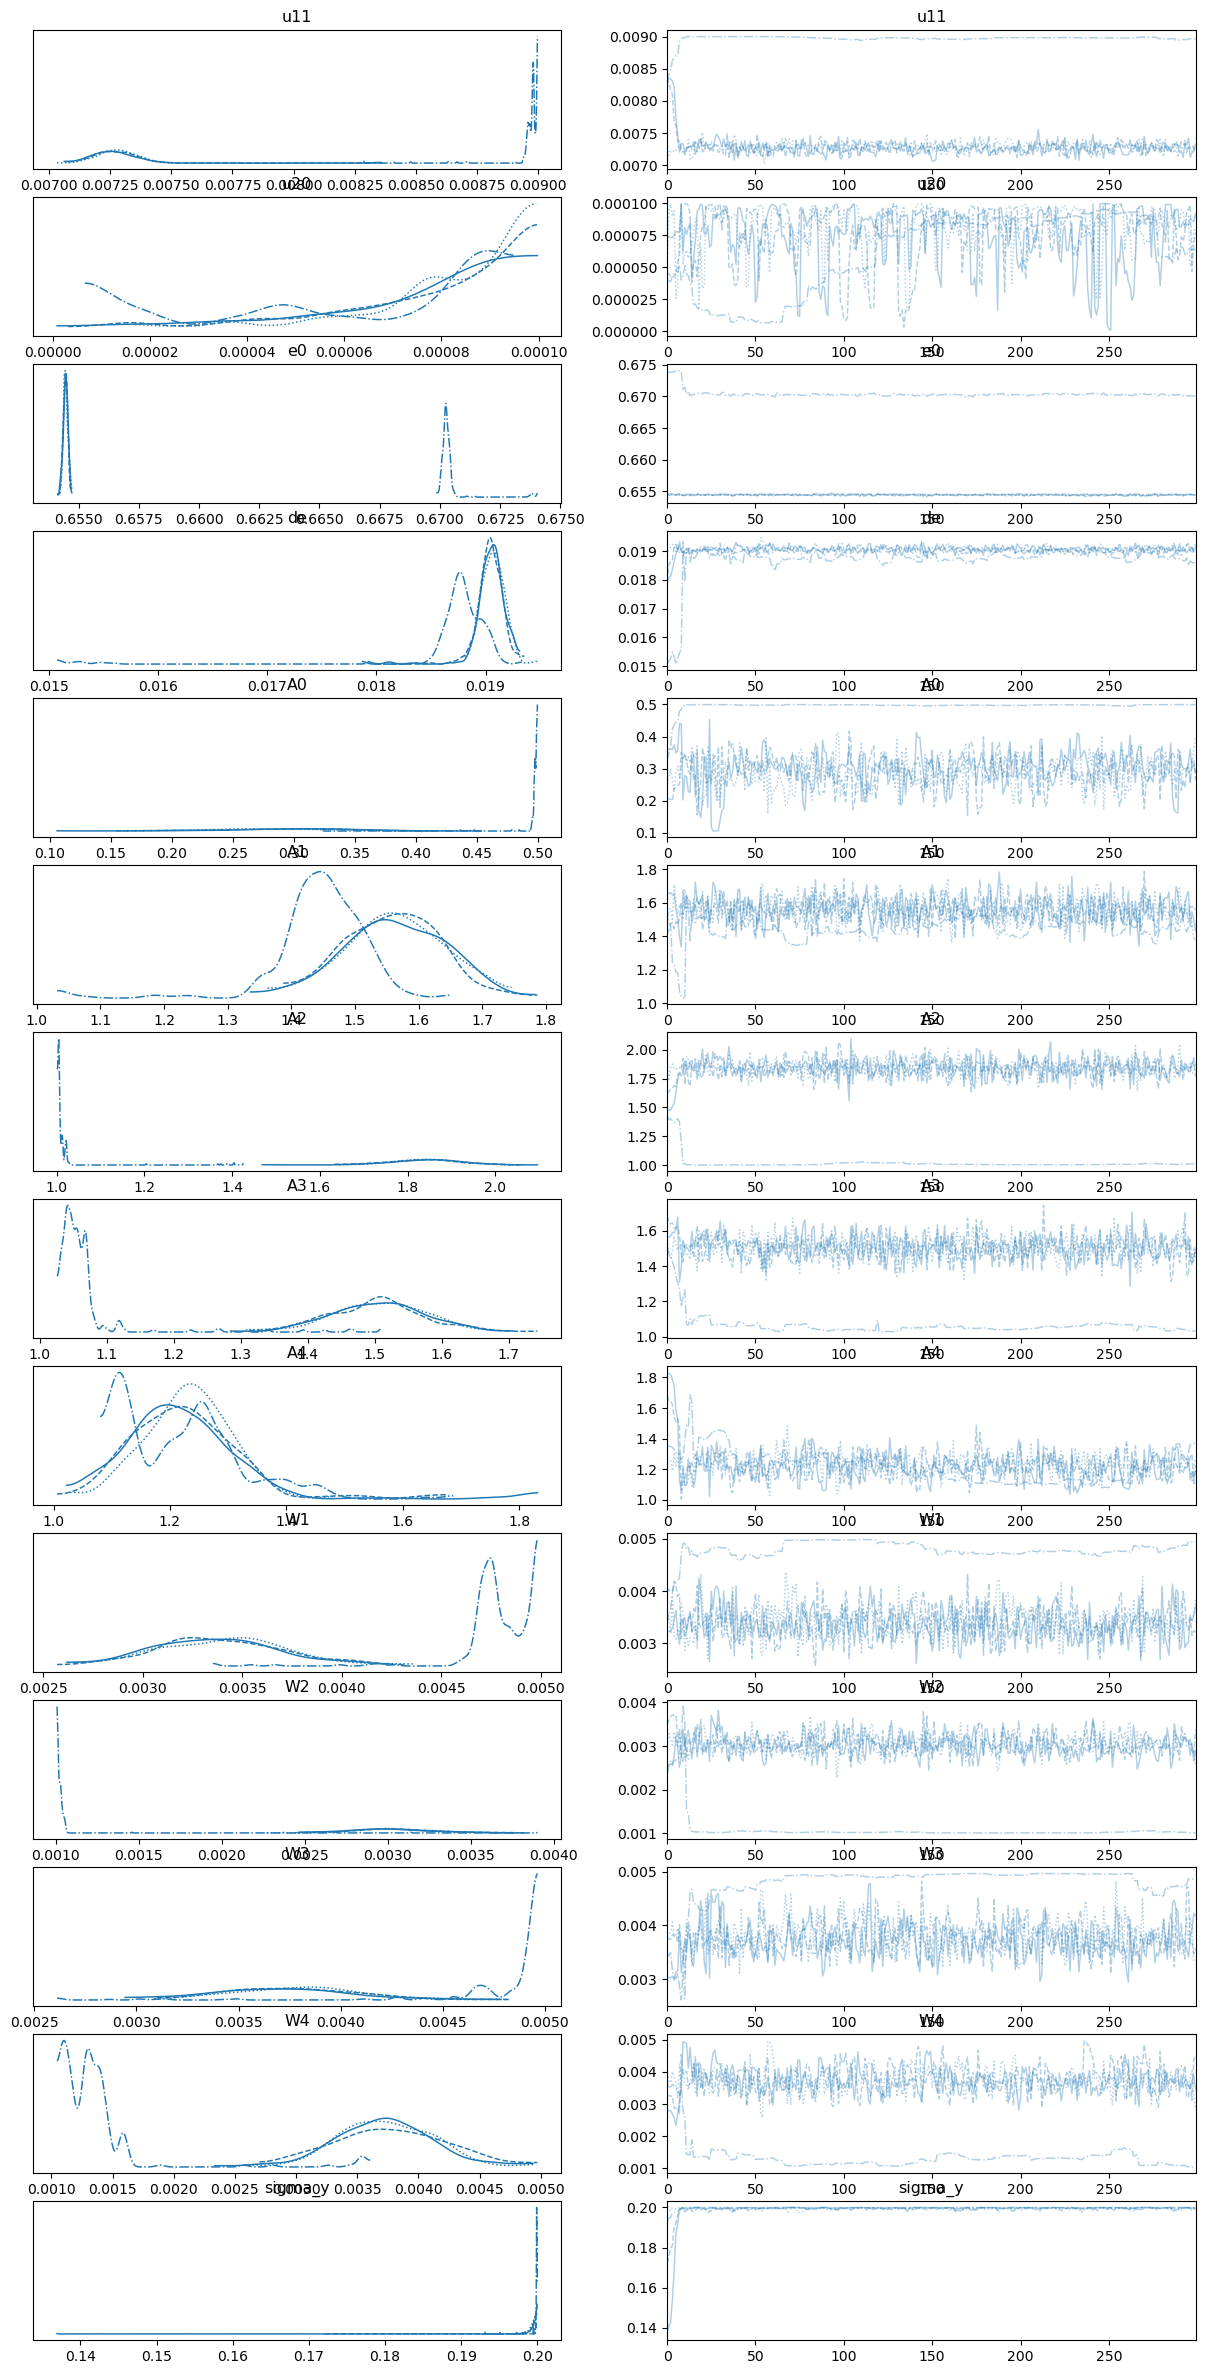

In [60]:
#guess the prior bounds
prior_W = [0.001,0.005]
prior_A = [1,2.2]
simu_prior_bounds = {'u11':[0.007, 0.009], 'u20':[0, 0.0001], 'e0':[0.64,0.68],'de':[0.01,0.02],
                     'A0':[0.1, 0.5], 'A1':prior_A,'A2':prior_A, 'A3':prior_A, 'A4':prior_A,
                     'W1':prior_W, 'W2':prior_W, 'W3':prior_W, 'W4':prior_W,'sigma_y':[0.05,0.2]}

#create the model 
simu_ham_model = Hamiltonian_model(simu_data, simu_prior_bounds)
with simu_ham_model:
    simu_idata = pm.sample(300, tune=10)

az.plot_trace(simu_idata, figsize=(15,30));

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
u11,0.007703,0.000740,0.007158,0.008999,0.000361,0.000276,7.266091,12.521715,1.549159
u20,0.000074,0.000025,0.000018,0.000100,0.000007,0.000005,20.152181,35.632170,1.151542
e0,0.658433,0.006903,0.654259,0.670401,0.003402,0.002600,7.342454,34.656489,1.528793
de,0.018965,0.000362,0.018678,0.019294,0.000081,0.000060,10.528712,66.149884,1.301259
A0,0.342200,0.100613,0.208266,0.499655,0.044077,0.035018,7.531567,36.612453,1.534667
A1,1.532633,0.090824,1.393038,1.702500,0.025243,0.018268,13.098730,208.154361,1.228136
A2,1.634123,0.363814,1.000567,1.951460,0.175748,0.133875,7.338189,13.066365,1.534888
A3,1.394739,0.202417,1.028058,1.605569,0.094846,0.071902,7.393705,33.599123,1.517299
A4,1.224809,0.097300,1.057392,1.369293,0.015915,0.011342,32.570081,107.527040,1.082240
W1,0.003742,0.000669,0.002961,0.004986,0.000300,0.000232,7.268490,16.971234,1.535939


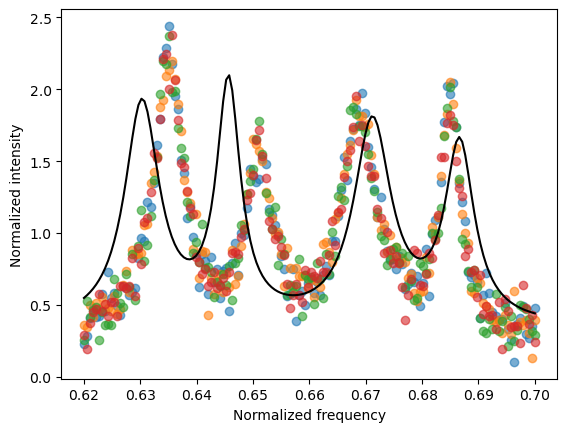

In [61]:
#summary the fitting results
simu_summary = az.summary(simu_idata,round_to=8)
display(simu_summary)

#plot data with the fitting curve
u11, u20,e0,de, A0, A1, A2, A3, A4, W1,W2,W3,W4 ,sigma_y= simu_summary['mean'].values
simu_theta = [u11, u20, e0,de, A0, A1, A2, A3, A4, W1, W2, W3, W4 ]
model_predictions = fit_curve(simu_normf, simu_theta)
plt.xlabel("Normalized frequency")
plt.ylabel("Normalized intensity")
plt.plot(simu_normf, y.T,'o',markersize = 6,alpha = 0.6)
plt.plot(simu_normf, model_predictions,c = 'k');

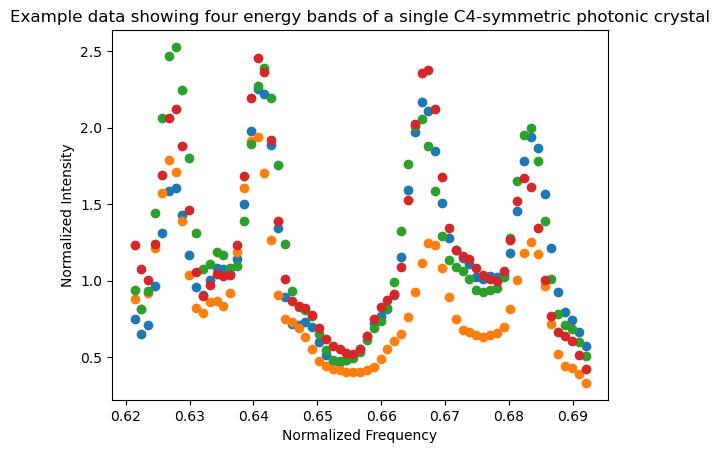

In [7]:
freq = real_data['normf'].to_numpy()
Nf = len(freq)
namef = ['y1','y2','y3','y4']
y = np.zeros((4,Nf))
y[:] = [real_data[namef[i]].to_numpy() for i in range(4)]

plt.plot(freq, y.T,'o')
plt.xlabel('Normalized Frequency')
plt.ylabel('Normalized Intensity')
plt.title('Example data showing four energy bands of a single C4-symmetric photonic crystal');
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [u11, u20, e0, de, A0, A1, A2, A3, A4, W1, W2, W3, W4, sigma_y]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 100 seconds.


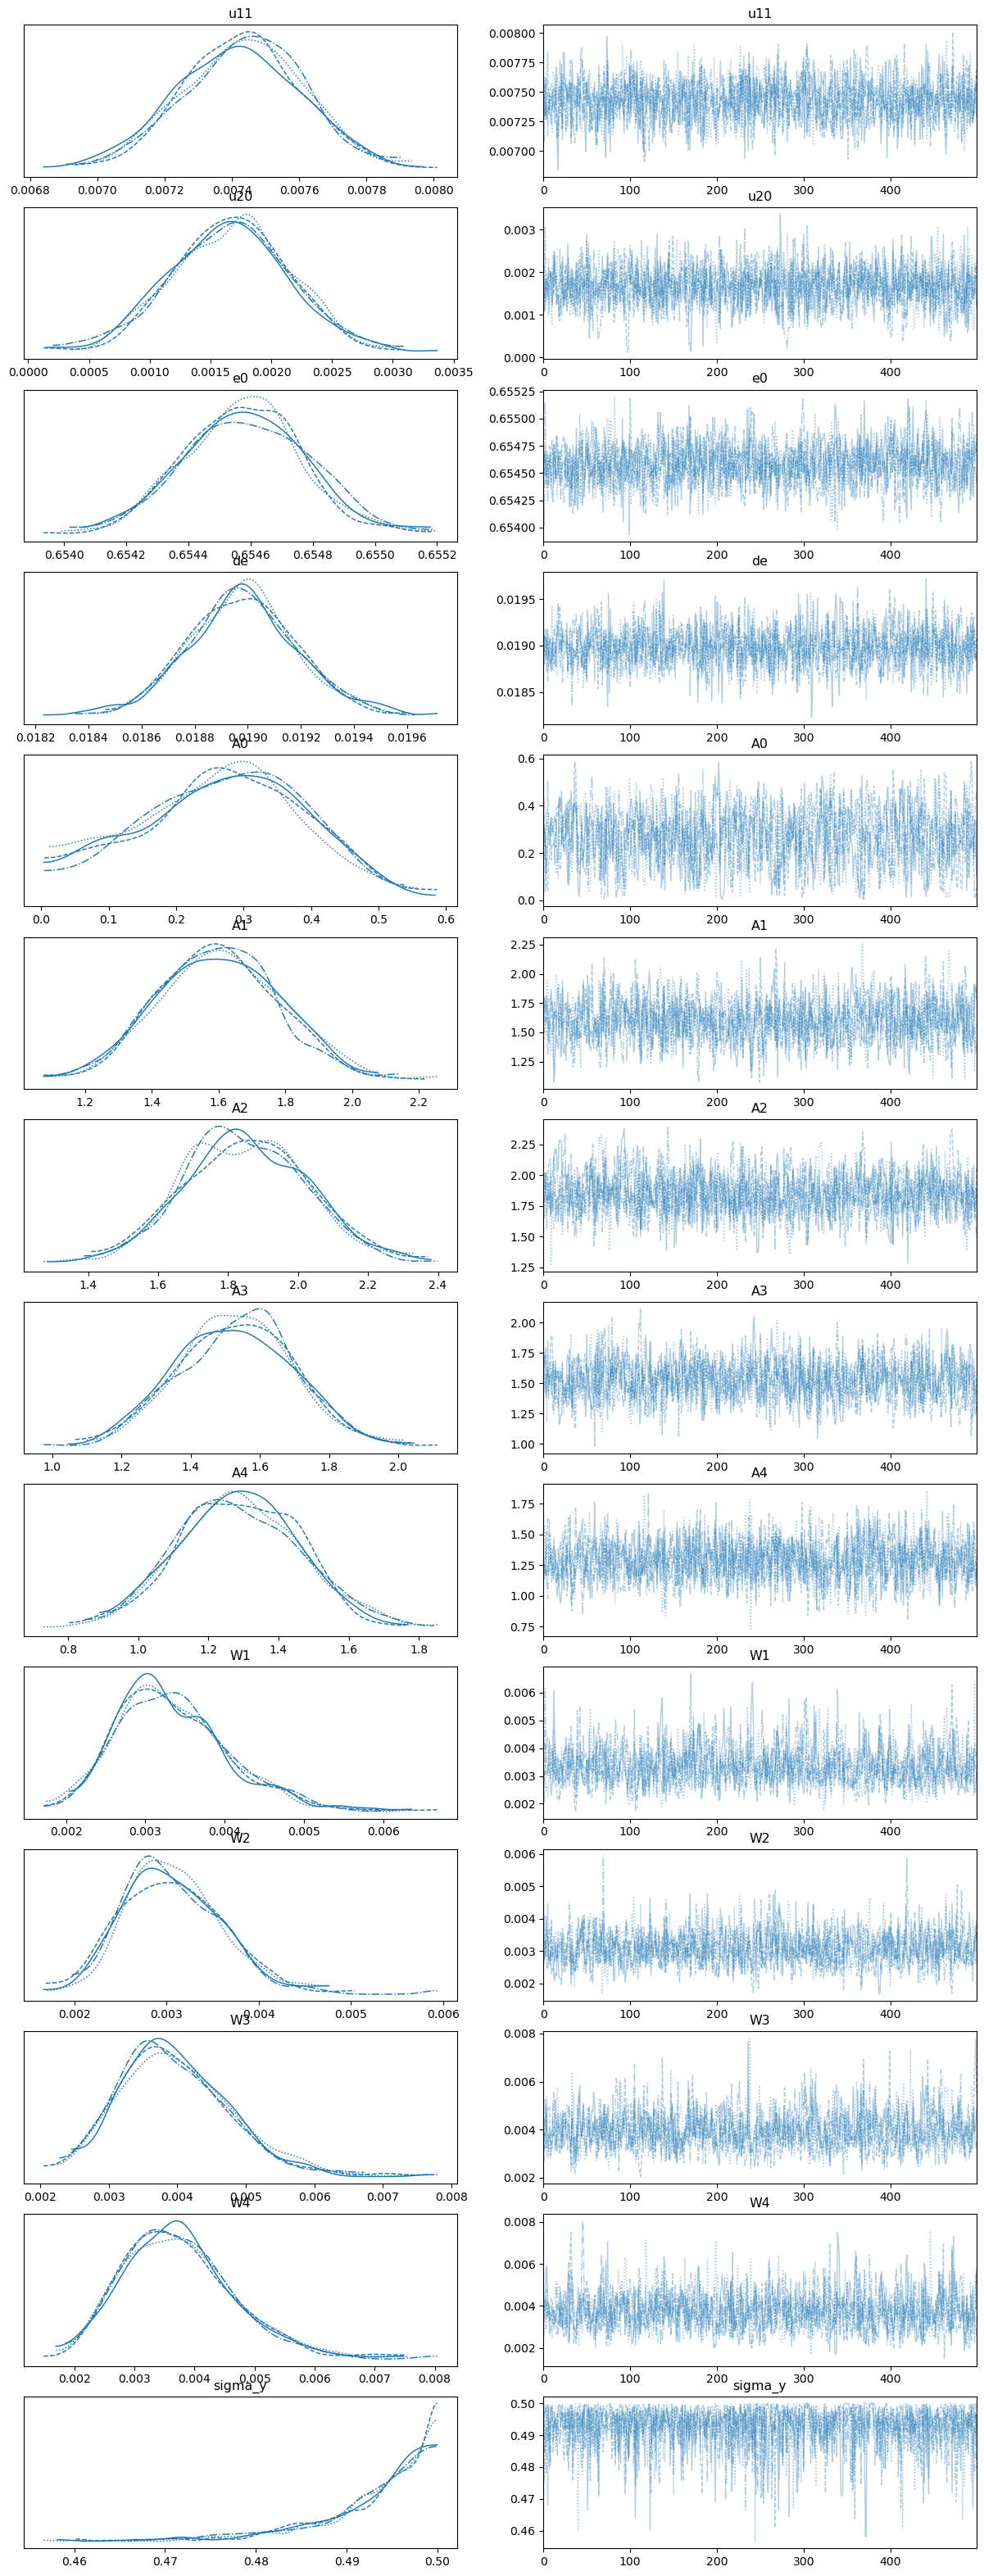

In [8]:
#guess the prior bounds
# u11, u20, neff, ratio, A0, A1, A2, A3, A4, W1, W2, W3, W4 = theta
prior_W = [0.001,0.03]
prior_A = [0.5,2.5]

simu_prior_bounds = {'u11':[0.005, 0.01], 'u20':[0, 0.005], 'e0':[0.64,0.67],'de':[0.005,0.025],
                     'A0':[0, 1], 'A1':prior_A,'A2':prior_A, 'A3':prior_A, 'A4':prior_A,
                     'W1':prior_W, 'W2':prior_W, 'W3':prior_W, 'W4':prior_W, 'sigma_y':[0.1,0.5]}

#create the model 
simu_ham_model = Hamiltonian_model(real_data,simu_prior_bounds)
with simu_ham_model:
    simu_idata = pm.sample(500)

az.plot_trace(simu_idata, figsize=(15,40));

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
u11,0.007431,0.000180,0.007096,0.007764,0.000005,0.000003,1588.926142,1555.844218,1.001203
u20,0.001663,0.000482,0.000763,0.002541,0.000013,0.000009,1313.867681,787.071439,1.002193
e0,0.654580,0.000195,0.654200,0.654933,0.000005,0.000004,1379.269805,1273.183822,1.002410
de,0.018981,0.000207,0.018589,0.019375,0.000005,0.000003,1734.516999,1568.855065,1.001262
A0,0.267796,0.119745,0.045368,0.478864,0.003902,0.002760,930.159520,902.008310,1.003360
A1,1.601863,0.185255,1.265490,1.943898,0.004956,0.003519,1402.849359,1539.774634,1.000913
A2,1.850739,0.177395,1.527894,2.191452,0.005021,0.003646,1258.115825,752.038302,1.001492
A3,1.531002,0.166211,1.220130,1.833484,0.004554,0.003226,1327.404489,1290.830492,1.000763
A4,1.287537,0.172057,0.984340,1.622213,0.004284,0.003030,1608.113469,1290.979921,0.999541
W1,0.003355,0.000713,0.002148,0.004727,0.000021,0.000015,1166.261455,1270.107168,0.999496


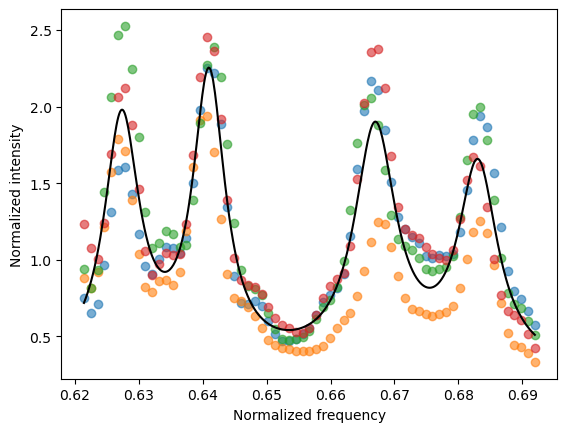

In [29]:
#summary the fitting results
summary = az.summary(simu_idata,round_to=8)
display(summary)

#plot data with the fitting curve
# u11, u20, neff,ratio, A0, A1, A2, A3, A4, W1,W2,W3,W4 = simu_summary['mean'].values
# simu_theta = [u11, u20,neff,ratio, A0, A1, A2, A3, A4, W1,W2,W3,W4]
# model_predictions = fit_curve(freq, theta)
# plt.xlabel("Normalized frequency")
# plt.ylabel("Normalized intensity")
# plt.errorbar(freq, intensity, intensity_sig, fmt = 'o')
# plt.plot(freq, model_predictions);

#plot data with the fitting curve
u11, u20,  e0,de,A0, A1, A2, A3, A4, W1,W2,W3,W4,sigma_y =summary['mean'].values
theta = [u11, u20,e0,de, A0, A1, A2, A3, A4, W1,W2,W3,W4]
freq_dense = np.linspace(freq[0],freq[-1],500)
model_predictions = fit_curve(freq_dense, theta)
plt.xlabel("Normalized frequency")
plt.ylabel("Normalized intensity")
plt.plot(freq, y.T,'o',markersize = 6,alpha = 0.6)
plt.plot(freq_dense, model_predictions,c = 'k');